## InceptonResNetV2-fine-tuning-V5
整体说明：
- 使用keras的InceptonResNetV2预训练模型进行fine-tuning，分别进行下面四种情况的fine-tuning
- 1、只训练自定义的输出层
- 2、冻结前698层，训练后面的层
- 3、冻结前618层，训练后面的层
- 4、冻结前499层，训练后面的层  
看哪种情况效果最好

修改内容：  
- 1、从V3版本中，修改lock_layers的bug

In [ ]:
'''
数据目录结构：
data/
    train/    #原始数据，train.zip解压后生成
        dog.0.jpg
        cat.0.jpg
        ...
    train2/   #按标签分目录后的数据（连接文件）
        dog/
            dog.0.jpg
            dog.1.jpg
            ...
        cat/
            cat.0.jpg
            cat.1.jpg
            ...
    train3/   #去除异常图片后的训练数据（连接文件）
        dog/    #9983张图片
            dog.0.jpg
            dog.1.jpg
            ...
        cat/    #9961张图片
            cat.0.jpg
            cat.1.jpg
            ...
    validation/  #去除异常图片后的验证数据（连接文件）
        dog/   #2496张图片
            dog001.jpg
            dog002.jpg
            ...
        cat/   #2490张图片
            cat001.jpg
            cat002.jpg
            ...
    test/     
        test/  #测试集数据，12500张图片
            1.jpg
            2.jpg
            ...
'''
import cv2
import time
import pandas as pd
from tqdm import tqdm   #进度条
from PIL import Image
from helper import *

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import *
from keras.optimizers import *
from keras.utils import *
from sklearn.utils import shuffle

# dimensions of our images.
img_width, img_height = 299, 299

train_data_dir = 'data/train2'
test_data_dir='data/test'


batch_size = 72   #19944/72=277  4986/72=69.25
epochs=30
VER=5
#模型权重文件
model_h5file_base="InceptonResNetV2-base-tuning-v{}.h5".format(VER)
model_h5file_tunig1="InceptonResNetV2-fine-tuning-1-v{}.h5".format(VER)
model_h5file_tunig2="InceptonResNetV2-fine-tuning-2-v{}.h5".format(VER)
model_h5file_tunig3="InceptonResNetV2-fine-tuning-3-v{}.h5".format(VER)

#预测结果文件
pred_file_base="pred-InceptonResNetV2-base-tuning-v{}.csv".format(VER)
pred_file_tuning1="pred-InceptonResNetV2-fine-tuning-1-v{}.csv".format(VER)
pred_file_tuning2="pred-InceptonResNetV2-fine-tuning-2-v{}.csv".format(VER)
pred_file_tuning3="pred-InceptonResNetV2-fine-tuning-3-v{}.csv".format(VER)

In [ ]:
#构造InceptionResNetV2模型
start = time.clock()
x_input = Input((img_width, img_height, 3))
x_input = Lambda(inception_resnet_v2.preprocess_input)(x_input)

base_model = InceptionResNetV2(input_tensor=x_input, weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3), pooling = 'avg')
for layer in base_model.layers:
    layer.trainable = False
    
y = Dropout(0.5)(base_model.output) #0.25-->0.5
y = Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001))(y)  #增加正则项
model = Model(inputs=base_model.input, outputs=y)

print("Load base model used time:", (time.clock() - start))


In [ ]:
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=adam,
             loss='binary_crossentropy',
             metrics=['accuracy'])


In [ ]:
# 输出模型结构图
#plot_model(model, to_file='model_InceptionResNetV2.png')

In [ ]:
#生成数据--全量读入内存
#X_train, Y_train=read_images_to_memory(train_data_dir, img_width, img_height, test=True)
#训练数据
X_train, Y_train=read_images_to_memory(train_data_dir, img_width, img_height)
X_train, Y_train=shuffle(X_train, Y_train)

#测试数据
X_test = load_test_data(12500, img_height, img_width, test_data_dir)


In [ ]:
model.summary()


In [ ]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_base, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min') #如发现loss相比上一个epoch训练没有下降,则经过3个epoch后停止训练
callbacks_list = [stopping,checkpoint]

history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)

In [ ]:
#可视化学习曲线
show_learning_curve(history)

In [ ]:
#预测结果    
predict_on_model(X_test, model, model_h5file_base, pred_file_base)

## 冻结前698层，再训练
放开Inception-resnet-C第5个block之后的层，不含Inception-resnet-C_5  
698 block8_5_ac 

In [9]:
# 设置需要冻结的层数
lock_layers(model, locked_layer_nums=698)

0 input_1
1 lambda_1
2 conv2d_1
3 batch_normalization_1
4 activation_1
5 conv2d_2
6 batch_normalization_2
7 activation_2
8 conv2d_3
9 batch_normalization_3
10 activation_3
11 max_pooling2d_1
12 conv2d_4
13 batch_normalization_4
14 activation_4
15 conv2d_5
16 batch_normalization_5
17 activation_5
18 max_pooling2d_2
19 conv2d_9
20 batch_normalization_9
21 activation_9
22 conv2d_7
23 conv2d_10
24 batch_normalization_7
25 batch_normalization_10
26 activation_7
27 activation_10
28 average_pooling2d_1
29 conv2d_6
30 conv2d_8
31 conv2d_11
32 conv2d_12
33 batch_normalization_6
34 batch_normalization_8
35 batch_normalization_11
36 batch_normalization_12
37 activation_6
38 activation_8
39 activation_11
40 activation_12
41 mixed_5b
42 conv2d_16
43 batch_normalization_16
44 activation_16
45 conv2d_14
46 conv2d_17
47 batch_normalization_14
48 batch_normalization_17
49 activation_14
50 activation_17
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 batch_normalization_13
55 batch_normalization_15
56 batch_n

In [10]:
model_h5file_base="InceptonResNetV2-base-tuning-v3.h5"  #直接用v3的文件，基础权重不再重练

model.load_weights(model_h5file_base)
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_tunig1, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min') #如果连续2个epoch训练,loss没有下降,则停止训练
callbacks_list = [stopping,checkpoint]

history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)

Train on 19944 samples, validate on 4986 samples
Epoch 1/30
19944/19944 [==============================] - 145s 7ms/step - loss: 0.0460 - acc: 0.9852 - val_loss: 0.0240 - val_acc: 0.9942

Epoch 00001: val_loss improved from inf to 0.02397, saving model to InceptonResNetV2-fine-tuning-1-v5.h5
Epoch 2/30
19944/19944 [==============================] - 135s 7ms/step - loss: 0.0158 - acc: 0.9962 - val_loss: 0.0371 - val_acc: 0.9930

Epoch 00002: val_loss did not improve from 0.02397
Epoch 3/30
19944/19944 [==============================] - 135s 7ms/step - loss: 0.0092 - acc: 0.9986 - val_loss: 0.0434 - val_acc: 0.9914

Epoch 00003: val_loss did not improve from 0.02397
Epoch 00003: early stopping


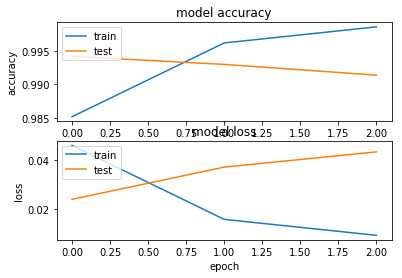

In [12]:
#可视化学习曲线
show_learning_curve(history)

In [13]:
#预测结果
predict_on_model(X_test, model, model_h5file_tunig1, pred_file_tuning1)

12500/12500 [==============================] - 69s 5ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/dogs-and-cats/helper.py:151: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(i, 'label', y_test[i])
100%|██████████| 12500/12500 [00:00<00:00, 140731.08it/s]


## 冻结前618层，再训练
放开Reduction-B之后的层，不含Reduction-B  
618 mixed_7a

In [14]:
# 设置需要冻结的层数
lock_layers(model, locked_layer_nums=618)

0 input_1
1 lambda_1
2 conv2d_1
3 batch_normalization_1
4 activation_1
5 conv2d_2
6 batch_normalization_2
7 activation_2
8 conv2d_3
9 batch_normalization_3
10 activation_3
11 max_pooling2d_1
12 conv2d_4
13 batch_normalization_4
14 activation_4
15 conv2d_5
16 batch_normalization_5
17 activation_5
18 max_pooling2d_2
19 conv2d_9
20 batch_normalization_9
21 activation_9
22 conv2d_7
23 conv2d_10
24 batch_normalization_7
25 batch_normalization_10
26 activation_7
27 activation_10
28 average_pooling2d_1
29 conv2d_6
30 conv2d_8
31 conv2d_11
32 conv2d_12
33 batch_normalization_6
34 batch_normalization_8
35 batch_normalization_11
36 batch_normalization_12
37 activation_6
38 activation_8
39 activation_11
40 activation_12
41 mixed_5b
42 conv2d_16
43 batch_normalization_16
44 activation_16
45 conv2d_14
46 conv2d_17
47 batch_normalization_14
48 batch_normalization_17
49 activation_14
50 activation_17
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 batch_normalization_13
55 batch_normalization_15
56 batch_n

514 block17_15
515 block17_15_ac
516 conv2d_138
517 batch_normalization_138
518 activation_138
519 conv2d_139
520 batch_normalization_139
521 activation_139
522 conv2d_137
523 conv2d_140
524 batch_normalization_137
525 batch_normalization_140
526 activation_137
527 activation_140
528 block17_16_mixed
529 block17_16_conv
530 block17_16
531 block17_16_ac
532 conv2d_142
533 batch_normalization_142
534 activation_142
535 conv2d_143
536 batch_normalization_143
537 activation_143
538 conv2d_141
539 conv2d_144
540 batch_normalization_141
541 batch_normalization_144
542 activation_141
543 activation_144
544 block17_17_mixed
545 block17_17_conv
546 block17_17
547 block17_17_ac
548 conv2d_146
549 batch_normalization_146
550 activation_146
551 conv2d_147
552 batch_normalization_147
553 activation_147
554 conv2d_145
555 conv2d_148
556 batch_normalization_145
557 batch_normalization_148
558 activation_145
559 activation_148
560 block17_18_mixed
561 block17_18_conv
562 block17_18
563 block17_18_ac
5

In [15]:
model.load_weights(model_h5file_base) 
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_tunig2, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min') #如果连续2个epoch训练,loss没有下降,则停止训练
callbacks_list = [stopping,checkpoint]
history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)

Train on 19944 samples, validate on 4986 samples
Epoch 1/30
19944/19944 [==============================] - 157s 8ms/step - loss: 0.0411 - acc: 0.9866 - val_loss: 0.0234 - val_acc: 0.9954

Epoch 00001: val_loss improved from inf to 0.02338, saving model to InceptonResNetV2-fine-tuning-2-v5.h5
Epoch 2/30
19944/19944 [==============================] - 143s 7ms/step - loss: 0.0108 - acc: 0.9981 - val_loss: 0.0223 - val_acc: 0.9960

Epoch 00002: val_loss improved from 0.02338 to 0.02235, saving model to InceptonResNetV2-fine-tuning-2-v5.h5
Epoch 3/30
19944/19944 [==============================] - 143s 7ms/step - loss: 0.0095 - acc: 0.9987 - val_loss: 0.0330 - val_acc: 0.9946

Epoch 00003: val_loss did not improve from 0.02235
Epoch 4/30
19944/19944 [==============================] - 143s 7ms/step - loss: 0.0066 - acc: 0.9993 - val_loss: 0.0251 - val_acc: 0.9948

Epoch 00004: val_loss did not improve from 0.02235
Epoch 00004: early stopping


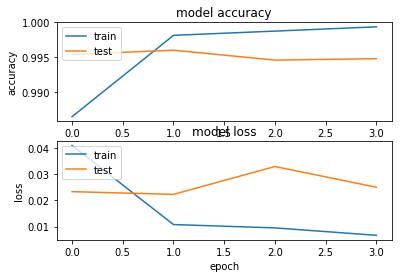

In [17]:
#可视化学习曲线
show_learning_curve(history)

In [18]:
#预测结果
predict_on_model(X_test, model, model_h5file_tunig2, pred_file_tuning2)

12500/12500 [==============================] - 75s 6ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/dogs-and-cats/helper.py:151: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(i, 'label', y_test[i])
100%|██████████| 12500/12500 [00:00<00:00, 143771.32it/s]


## 冻结前746层，再训练
放开Inception-resnet-C 第8个block之后的层，不含包Inception-resnet-C_8  
746 block8_8_ac

In [19]:
# 设置需要冻结的层数
lock_layers(model, locked_layer_nums=746)

0 input_1
1 lambda_1
2 conv2d_1
3 batch_normalization_1
4 activation_1
5 conv2d_2
6 batch_normalization_2
7 activation_2
8 conv2d_3
9 batch_normalization_3
10 activation_3
11 max_pooling2d_1
12 conv2d_4
13 batch_normalization_4
14 activation_4
15 conv2d_5
16 batch_normalization_5
17 activation_5
18 max_pooling2d_2
19 conv2d_9
20 batch_normalization_9
21 activation_9
22 conv2d_7
23 conv2d_10
24 batch_normalization_7
25 batch_normalization_10
26 activation_7
27 activation_10
28 average_pooling2d_1
29 conv2d_6
30 conv2d_8
31 conv2d_11
32 conv2d_12
33 batch_normalization_6
34 batch_normalization_8
35 batch_normalization_11
36 batch_normalization_12
37 activation_6
38 activation_8
39 activation_11
40 activation_12
41 mixed_5b
42 conv2d_16
43 batch_normalization_16
44 activation_16
45 conv2d_14
46 conv2d_17
47 batch_normalization_14
48 batch_normalization_17
49 activation_14
50 activation_17
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 batch_normalization_13
55 batch_normalization_15
56 batch_n

473 activation_127
474 conv2d_125
475 conv2d_128
476 batch_normalization_125
477 batch_normalization_128
478 activation_125
479 activation_128
480 block17_13_mixed
481 block17_13_conv
482 block17_13
483 block17_13_ac
484 conv2d_130
485 batch_normalization_130
486 activation_130
487 conv2d_131
488 batch_normalization_131
489 activation_131
490 conv2d_129
491 conv2d_132
492 batch_normalization_129
493 batch_normalization_132
494 activation_129
495 activation_132
496 block17_14_mixed
497 block17_14_conv
498 block17_14
499 block17_14_ac
500 conv2d_134
501 batch_normalization_134
502 activation_134
503 conv2d_135
504 batch_normalization_135
505 activation_135
506 conv2d_133
507 conv2d_136
508 batch_normalization_133
509 batch_normalization_136
510 activation_133
511 activation_136
512 block17_15_mixed
513 block17_15_conv
514 block17_15
515 block17_15_ac
516 conv2d_138
517 batch_normalization_138
518 activation_138
519 conv2d_139
520 batch_normalization_139
521 activation_139
522 conv2d_137


In [20]:
model.load_weights(model_h5file_base) 
adam = optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_tunig3, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min') #如果连续2个epoch训练,loss没有下降,则停止训练
callbacks_list = [stopping,checkpoint]

history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)


Train on 19944 samples, validate on 4986 samples
Epoch 1/30
19944/19944 [==============================] - 143s 7ms/step - loss: 0.0517 - acc: 0.9831 - val_loss: 0.0446 - val_acc: 0.9910

Epoch 00001: val_loss improved from inf to 0.04462, saving model to InceptonResNetV2-fine-tuning-3-v5.h5
Epoch 2/30
19944/19944 [==============================] - 132s 7ms/step - loss: 0.0239 - acc: 0.9927 - val_loss: 0.0517 - val_acc: 0.9892

Epoch 00002: val_loss did not improve from 0.04462
Epoch 3/30
19944/19944 [==============================] - 132s 7ms/step - loss: 0.0121 - acc: 0.9975 - val_loss: 0.0470 - val_acc: 0.9910

Epoch 00003: val_loss did not improve from 0.04462
Epoch 00003: early stopping


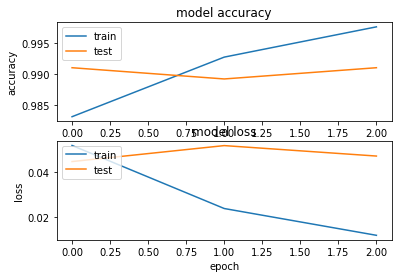

In [22]:
#可视化学习曲线
show_learning_curve(history)

In [23]:
#预测结果
predict_on_model(X_test, model, model_h5file_tunig3, pred_file_tuning3)

12500/12500 [==============================] - 74s 6ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/dogs-and-cats/helper.py:151: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(i, 'label', y_test[i])
100%|██████████| 12500/12500 [00:00<00:00, 145528.83it/s]
